In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


real_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
fake_df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv') 

real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [10]:
real_df['label'] = 1
fake_df['label'] = 0
df = pd.concat([real_df, fake_df], axis=0, ignore_index=True)

In [11]:
# drop columns we aren't using in this application
data = df
data.drop(['title'], inplace=True, axis=1)
data.drop(['subject'], inplace=True, axis=1)
data.drop(['date'], inplace=True, axis=1)
data.head()

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# shuffle the data
df = shuffle(df).reset_index(drop=True)

# separate X and y
y = np.array(df.label)
X = df.drop(['label'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31428, 1)
(13470, 1)
(31428,)
(13470,)


Installing the required libraries:

In [14]:
!conda install -y pytorch torchvision cudatoolkit=10.1 -c pytorch
!pip install transformers

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=10.1
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.4.13  |       h06a4308_1         114 KB
    certifi-2020.12.5          |   py36h06a4308_0         140 KB
    conda-4.10.1               |   py36h06a4308_1         2.9 MB
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following packages will be UPDATED:

  ca-certificates                                2020.1.1-0 --> 2021.4.13-h06a4308_1
  certifi                                 2019.11.28-py36_0 --> 2020.12.5-py36h06a4308_0
  conda                                        4.8.2-py36_0 --> 4.10.1-py36h06a4308_1



ca-certificates-2021 | 114 KB    | ##########################

In [15]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

I am going to freeze all the pretrained portion of the network and add a new section at the end of the network

In [16]:
# Freeze the pre trained parameters
for param in model.parameters():
    param.requires_grad = False

# Add three new layers at the end of the network
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)

model = model.to(device)

In [17]:
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [18]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [22]:
print_every = 300

total_loss = 0
all_losses = []
y_train_iter = iter(y_train)
CUDA_LAUNCH_BLOCKING = 1
i = 0
model.train()

for idx, row in X_train.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor(next(y_train_iter)).long().to(device)

    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

    overall_output = F.softmax(overall_output[0], dim=-1)

    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)

    loss = criterion(overall_output, label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if i % print_every == 0 and i > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(i, len(X_train), average_loss))
        all_losses.append(average_loss)
        total_loss = 0
    i += 1
        
    

300/31428. Average loss: 0.07085626225842134
600/31428. Average loss: 0.07303782542482623
900/31428. Average loss: 0.07211781021029613
1200/31428. Average loss: 0.08442383180705898
1500/31428. Average loss: 0.08169077116979982
1800/31428. Average loss: 0.07372230880792813
2100/31428. Average loss: 0.06423122598094172
2400/31428. Average loss: 0.07929248593039423
2700/31428. Average loss: 0.07127317615336021
3000/31428. Average loss: 0.07260900748670035
3300/31428. Average loss: 0.06577204408344642
3600/31428. Average loss: 0.08096479379615933
3900/31428. Average loss: 0.07207543660666185
4200/31428. Average loss: 0.06808792468160542
4500/31428. Average loss: 0.07047164602049785
4800/31428. Average loss: 0.07620611414111106
5100/31428. Average loss: 0.07344354535180173
5400/31428. Average loss: 0.06732641443113305
5700/31428. Average loss: 0.08365192562256804
6000/31428. Average loss: 0.07040142473796701
6300/31428. Average loss: 0.0822546232783255
6600/31428. Average loss: 0.0687819814

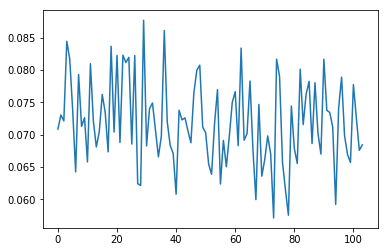

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
torch.save(model.state_dict(), "model_after_train.pt")

plt.plot(all_losses)

## Now I will test the accuracy of the model on the test set

In [26]:
total = len(X_test)
number_right = 0
i = 0
y_test_iter = iter(y_test)
model.eval()
with torch.no_grad():
    for idx, row in X_test.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor(next(y_test_iter)).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        try:
            for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
        except RuntimeError:
            print("GPU out of memory, skipping this entry.")
            continue
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
 
        if result == label.item():
            number_right += 1
            
        if i % print_every == 0 and i > 0:
            print("{}/{}. Current accuracy: {}".format(i, total, number_right / i))
        i += 1
print("Accuracy on test data: {}".format(number_right / total))
            
        

300/13470. Current accuracy: 0.97
600/13470. Current accuracy: 0.9616666666666667
900/13470. Current accuracy: 0.9588888888888889
1200/13470. Current accuracy: 0.9625
1500/13470. Current accuracy: 0.9646666666666667
1800/13470. Current accuracy: 0.9666666666666667
2100/13470. Current accuracy: 0.9657142857142857
2400/13470. Current accuracy: 0.96625
2700/13470. Current accuracy: 0.965925925925926
3000/13470. Current accuracy: 0.9656666666666667
3300/13470. Current accuracy: 0.9642424242424242
3600/13470. Current accuracy: 0.9652777777777778
3900/13470. Current accuracy: 0.9661538461538461
4200/13470. Current accuracy: 0.9661904761904762
4500/13470. Current accuracy: 0.9644444444444444
4800/13470. Current accuracy: 0.9652083333333333
5100/13470. Current accuracy: 0.9631372549019608
5400/13470. Current accuracy: 0.9622222222222222
5700/13470. Current accuracy: 0.9628070175438597
6000/13470. Current accuracy: 0.9621666666666666
6300/13470. Current accuracy: 0.9623809523809523
6600/13470. 